### Deep Learning Neural Networks | 2021
    
### Musical Instruments Classifier using Convolutional Neural Networks (CNNs)
##### Group 18 [TP2]   
Beatriz Crispim (m20201835)<br>
Inês Resende (m20200844)<br>
João Tiago Homem (m20201791)<br>
Tiago Rodrigues (m20201771)<br>

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from os import listdir
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow_hub as hub
from keras.models import Model
from keras.layers import Input
from keras.layers import Input, SpatialDropout2D
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2

In [203]:
def extract_data(base_dir, verbose=True):
    training_dir = os.path.join(base_dir, 'train') 
    test_dir = os.path.join(base_dir, 'test') 
    val_dir = os.path.join(base_dir, 'valid')

    # Get data:
    train_data_generator = ImageDataGenerator(rescale=1./255)
    test_data_generator = ImageDataGenerator(rescale=1./255)
    validation_data_generator = ImageDataGenerator(rescale=1./255)

    # Note: do not forget to later adjust the value of the batch_size so you can obtain smoother training and validation curves:
    train_generator = train_data_generator.flow_from_directory(training_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    validation_generator = validation_data_generator.flow_from_directory(val_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    
    return train_generator, test_generator, validation_generator

def plot_results(history):
    # Results analysis:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=100)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
   
    sns.lineplot(x=epochs, y=acc, label='Training',ax=axes[0])
    sns.lineplot(x=epochs, y=val_acc, label='Validation',ax=axes[0])
    axes[0].set_xlabel('Epochs', fontsize = 10) 
    axes[0].set_ylabel('Accuracy', fontsize = 10) 
    axes[0].grid(color='grey', linestyle='-.', linewidth=0.5)
    
    sns.lineplot(x=epochs, y=loss, label='Training',ax=axes[1])
    sns.lineplot(x=epochs,y= val_loss, label='Validation',ax=axes[1])
    axes[1].set_xlabel('Epochs', fontsize = 10) 
    axes[1].set_ylabel('Loss', fontsize = 10) 
    axes[1].grid(color='grey', linestyle='-.', linewidth=0.5)

In [3]:
base_dir = os.getcwd() + '/instruments' 
train_generator, test_generator, val_generator = extract_data(base_dir=base_dir)

Found 2921 images belonging to 20 classes.
Found 300 images belonging to 20 classes.
Found 300 images belonging to 20 classes.


In [4]:
#simple model with 2 conv layers of 16 filters
baseline_model_1 = Sequential()

baseline_model_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_1.add(Flatten())
# MLP - hidden layer:
baseline_model_1.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 20)                6

In [5]:
# add 1 conv layer with 32 filters
baseline_model_1_1 = Sequential()

baseline_model_1_1.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_1_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_1_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_1_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_1_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_1_1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_1_1.add(Flatten())
# MLP - hidden layer:
baseline_model_1_1.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 16)        

In [58]:
# 2 conv layers with 32 filters
baseline_model_2 = Sequential()

baseline_model_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_2.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_2.add(Flatten())
# MLP - hidden layer:
baseline_model_2.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 6272)              0         
                                                                 
 dense_22 (Dense)            (None, 20)              

In [59]:
#add one hidden layer to mlp
baseline_model_2_1 = Sequential()

baseline_model_2_1.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_2_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2_1.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2_1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_2_1.add(Flatten())
# MLP - hidden layer:
baseline_model_2_1.add(Dense(120, activation='relu'))
baseline_model_2_1.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_2_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 6272)              0         
                                                                 
 dense_23 (Dense)            (None, 120)             

In [8]:
#3 conv layers
baseline_model_2_2 = Sequential()

baseline_model_2_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2_2.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2_2.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_2_2.add(Flatten())
# MLP - hidden layer:
baseline_model_2_2.add(Dense(120, activation='relu'))
baseline_model_2_2.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_2_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 32)        

In [9]:
#3 conv layers with kernel size (5,5)
baseline_model_2_3 = Sequential()

baseline_model_2_3.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_2_3.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2_3.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2_3.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_2_3.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_2_3.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_2_3.add(Flatten())
# MLP - hidden layer:
baseline_model_2_3.add(Dense(120, activation='relu'))
baseline_model_2_3.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_2_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        25632     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 32)          25632     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 32)        

In [10]:
#three conv layers sort descending
baseline_model_3 = Sequential()

baseline_model_3.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_3.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_3.add(Flatten())
# MLP - hidden layer:
baseline_model_3.add(Dense(120, activation='relu'))
baseline_model_3.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 60, 60, 128)       9728      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 64)        204864    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 32)          51232     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 32)        

In [11]:
#three conv layers sort ascending
baseline_model_3_1 = Sequential()

baseline_model_3_1.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_3_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3_1.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3_1.add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3_1.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3_1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_3_1.add(Flatten())
# MLP - hidden layer:
baseline_model_3_1.add(Dense(120, activation='relu'))
baseline_model_3_1.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_3_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 9, 9, 128)         204928    
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 4, 128)       

In [12]:
#three conv layers ascending with more filters + more neurons
baseline_model_3_2 = Sequential()

baseline_model_3_2 .add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
baseline_model_3_2 .add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3_2 .add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3_2 .add(MaxPooling2D(pool_size=(2, 2)))

baseline_model_3_2.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='valid'))
baseline_model_3_2.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
baseline_model_3_2 .add(Flatten())
# MLP - hidden layer:
baseline_model_3_2.add(Dense(2048, activation='relu'))
baseline_model_3_2.add(Dense(1024, activation='relu'))
baseline_model_3_2.add(Dense(20, activation='softmax'))

# Check built model:
baseline_model_3_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 26, 26, 64)        51264     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 9, 9, 128)         204928    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 4, 4, 128)       

In [13]:
baseline_model_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_1_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_2_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_2_2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_2_3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_3.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_3_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
baseline_model_3_2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])

In [14]:
# Common attributes:
steps_per_epoch = 90
epochs = 500
validation_steps = 9
patience=50
shuffle=True

early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [15]:
history_1 = baseline_model_1.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 6s 57ms/step - loss: 2.7901 - acc: 0.1610 - val_loss: 2.4994 - val_acc: 0.3125
Epoch 2/500
90/90 [==============================] - 5s 53ms/step - loss: 2.1635 - acc: 0.3749 - val_loss: 1.9709 - val_acc: 0.4410
Epoch 3/500
90/90 [==============================] - 5s 52ms/step - loss: 1.7532 - acc: 0.4932 - val_loss: 1.7748 - val_acc: 0.4653
Epoch 4/500
90/90 [==============================] - 5s 51ms/step - loss: 1.4702 - acc: 0.5733 - val_loss: 1.7084 - val_acc: 0.5139
Epoch 5/500
90/90 [==============================] - 4s 49ms/step - loss: 1.2380 - acc: 0.6405 - val_loss: 1.5988 - val_acc: 0.5521
Epoch 6/500
90/90 [==============================] - 5s 51ms/step - loss: 1.0316 - acc: 0.7014 - val_loss: 1.5177 - val_acc: 0.5590
Epoch 7/500
90/90 [==============================] - 5s 53ms/step - loss: 0.8309 - acc: 0.7592 - val_loss: 1.7155 - val_acc: 0.5556
Epoch 8/500
90/90 [==============================] - 5s 53ms/step - loss: 0.

In [16]:
history_1_1 = baseline_model_1_1.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 6s 64ms/step - loss: 2.8801 - acc: 0.1197 - val_loss: 2.7303 - val_acc: 0.1701
Epoch 2/500
90/90 [==============================] - 6s 63ms/step - loss: 2.3377 - acc: 0.3126 - val_loss: 2.2202 - val_acc: 0.3507
Epoch 3/500
90/90 [==============================] - 6s 63ms/step - loss: 1.9708 - acc: 0.4400 - val_loss: 1.9712 - val_acc: 0.4375
Epoch 4/500
90/90 [==============================] - 6s 62ms/step - loss: 1.8024 - acc: 0.4830 - val_loss: 1.8507 - val_acc: 0.4271
Epoch 5/500
90/90 [==============================] - 6s 64ms/step - loss: 1.6750 - acc: 0.5093 - val_loss: 1.7425 - val_acc: 0.5382
Epoch 6/500
90/90 [==============================] - 6s 66ms/step - loss: 1.5476 - acc: 0.5387 - val_loss: 1.6069 - val_acc: 0.5556
Epoch 7/500
90/90 [==============================] - 6s 64ms/step - loss: 1.4394 - acc: 0.5747 - val_loss: 1.5552 - val_acc: 0.5903
Epoch 8/500
90/90 [==============================] - 6s 64ms/step - loss: 1.

In [63]:
history_2 = baseline_model_2.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 7s 78ms/step - loss: 2.6086 - acc: 0.2265 - val_loss: 2.2067 - val_acc: 0.3993
Epoch 2/500
90/90 [==============================] - 7s 74ms/step - loss: 1.9090 - acc: 0.4424 - val_loss: 1.8029 - val_acc: 0.4826
Epoch 3/500
90/90 [==============================] - 6s 70ms/step - loss: 1.5606 - acc: 0.5460 - val_loss: 1.6205 - val_acc: 0.5556
Epoch 4/500
90/90 [==============================] - 7s 72ms/step - loss: 1.2099 - acc: 0.6479 - val_loss: 1.6323 - val_acc: 0.5243
Epoch 5/500
90/90 [==============================] - 6s 71ms/step - loss: 0.9239 - acc: 0.7252 - val_loss: 1.6413 - val_acc: 0.5694
Epoch 6/500
90/90 [==============================] - 6s 70ms/step - loss: 0.6662 - acc: 0.8120 - val_loss: 1.6501 - val_acc: 0.5764
Epoch 7/500
90/90 [==============================] - 6s 70ms/step - loss: 0.4791 - acc: 0.8582 - val_loss: 1.7136 - val_acc: 0.5938
Epoch 8/500
90/90 [==============================] - 6s 70ms/step - loss: 0.

Epoch 62/500
90/90 [==============================] - 6s 70ms/step - loss: 1.3304e-04 - acc: 1.0000 - val_loss: 4.1067 - val_acc: 0.6076
Epoch 63/500
90/90 [==============================] - 6s 69ms/step - loss: 1.2598e-04 - acc: 1.0000 - val_loss: 4.2321 - val_acc: 0.6007
Epoch 64/500
90/90 [==============================] - 6s 69ms/step - loss: 1.2004e-04 - acc: 1.0000 - val_loss: 4.2555 - val_acc: 0.6111
Epoch 65/500
90/90 [==============================] - 6s 69ms/step - loss: 1.1383e-04 - acc: 1.0000 - val_loss: 4.1580 - val_acc: 0.6181
Epoch 66/500
90/90 [==============================] - 6s 69ms/step - loss: 1.0571e-04 - acc: 1.0000 - val_loss: 4.1548 - val_acc: 0.6076
Epoch 67/500
90/90 [==============================] - 6s 70ms/step - loss: 9.9855e-05 - acc: 1.0000 - val_loss: 4.2664 - val_acc: 0.6042
Epoch 68/500
90/90 [==============================] - 6s 70ms/step - loss: 9.3574e-05 - acc: 1.0000 - val_loss: 4.2995 - val_acc: 0.5972
Epoch 69/500
90/90 [=====================

In [64]:
history_2_1 = baseline_model_2_1.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 7s 75ms/step - loss: 2.6777 - acc: 0.1978 - val_loss: 2.2538 - val_acc: 0.3264
Epoch 2/500
90/90 [==============================] - 7s 74ms/step - loss: 1.9751 - acc: 0.4291 - val_loss: 1.8761 - val_acc: 0.4549
Epoch 3/500
90/90 [==============================] - 7s 75ms/step - loss: 1.5882 - acc: 0.5261 - val_loss: 1.7118 - val_acc: 0.5625
Epoch 4/500
90/90 [==============================] - 7s 74ms/step - loss: 1.2805 - acc: 0.6269 - val_loss: 1.5468 - val_acc: 0.5590
Epoch 5/500
90/90 [==============================] - 7s 73ms/step - loss: 0.9796 - acc: 0.7160 - val_loss: 1.6872 - val_acc: 0.5660
Epoch 6/500
90/90 [==============================] - 7s 73ms/step - loss: 0.6801 - acc: 0.8057 - val_loss: 1.5710 - val_acc: 0.5799
Epoch 7/500
90/90 [==============================] - 7s 73ms/step - loss: 0.5195 - acc: 0.8453 - val_loss: 1.6015 - val_acc: 0.5833
Epoch 8/500
90/90 [==============================] - 7s 74ms/step - loss: 0.

In [19]:
history_2_2 = baseline_model_2_2.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 7s 71ms/step - loss: 2.8270 - acc: 0.1355 - val_loss: 2.7147 - val_acc: 0.1875
Epoch 2/500
90/90 [==============================] - 6s 69ms/step - loss: 2.2377 - acc: 0.3210 - val_loss: 2.0233 - val_acc: 0.4167
Epoch 3/500
90/90 [==============================] - 6s 69ms/step - loss: 1.9060 - acc: 0.4330 - val_loss: 1.7553 - val_acc: 0.5069
Epoch 4/500
90/90 [==============================] - 6s 70ms/step - loss: 1.6921 - acc: 0.5002 - val_loss: 1.6273 - val_acc: 0.5556
Epoch 5/500
90/90 [==============================] - 6s 70ms/step - loss: 1.5178 - acc: 0.5394 - val_loss: 1.6073 - val_acc: 0.5417
Epoch 6/500
90/90 [==============================] - 6s 69ms/step - loss: 1.3404 - acc: 0.6055 - val_loss: 1.4376 - val_acc: 0.5972
Epoch 7/500
90/90 [==============================] - 6s 71ms/step - loss: 1.1538 - acc: 0.6590 - val_loss: 1.4677 - val_acc: 0.5799
Epoch 8/500
90/90 [==============================] - 6s 71ms/step - loss: 0.

In [20]:
history_2_3 = baseline_model_2_3.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 7s 76ms/step - loss: 2.8691 - acc: 0.1229 - val_loss: 2.7066 - val_acc: 0.2014
Epoch 2/500
90/90 [==============================] - 7s 74ms/step - loss: 2.5007 - acc: 0.2545 - val_loss: 2.4797 - val_acc: 0.2535
Epoch 3/500
90/90 [==============================] - 7s 75ms/step - loss: 2.1679 - acc: 0.3441 - val_loss: 2.0253 - val_acc: 0.4167
Epoch 4/500
90/90 [==============================] - 7s 74ms/step - loss: 1.9460 - acc: 0.4130 - val_loss: 1.9674 - val_acc: 0.4375
Epoch 5/500
90/90 [==============================] - 7s 74ms/step - loss: 1.7949 - acc: 0.4606 - val_loss: 1.6963 - val_acc: 0.5035
Epoch 6/500
90/90 [==============================] - 7s 74ms/step - loss: 1.6061 - acc: 0.5100 - val_loss: 1.6280 - val_acc: 0.5069
Epoch 7/500
90/90 [==============================] - 7s 74ms/step - loss: 1.5171 - acc: 0.5376 - val_loss: 1.5379 - val_acc: 0.5660
Epoch 8/500
90/90 [==============================] - 7s 74ms/step - loss: 1.

In [21]:
history_3 = baseline_model_3.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 20s 221ms/step - loss: 2.9368 - acc: 0.0998 - val_loss: 2.8728 - val_acc: 0.1215
Epoch 2/500
90/90 [==============================] - 20s 220ms/step - loss: 2.6556 - acc: 0.2083 - val_loss: 2.3936 - val_acc: 0.2778
Epoch 3/500
90/90 [==============================] - 21s 230ms/step - loss: 2.2964 - acc: 0.3168 - val_loss: 2.2109 - val_acc: 0.3264
Epoch 4/500
90/90 [==============================] - 21s 230ms/step - loss: 2.0498 - acc: 0.3871 - val_loss: 1.8691 - val_acc: 0.4861
Epoch 5/500
90/90 [==============================] - 20s 225ms/step - loss: 1.8347 - acc: 0.4449 - val_loss: 1.8249 - val_acc: 0.4965
Epoch 6/500
90/90 [==============================] - 20s 225ms/step - loss: 1.6414 - acc: 0.5087 - val_loss: 1.8775 - val_acc: 0.4792
Epoch 7/500
90/90 [==============================] - 20s 225ms/step - loss: 1.4663 - acc: 0.5485 - val_loss: 1.8411 - val_acc: 0.5208
Epoch 8/500
90/90 [==============================] - 20s 225ms

Epoch 120/500
90/90 [==============================] - 20s 226ms/step - loss: 4.5951e-06 - acc: 1.0000 - val_loss: 7.3418 - val_acc: 0.5799
Epoch 121/500
90/90 [==============================] - 20s 226ms/step - loss: 4.3491e-06 - acc: 1.0000 - val_loss: 7.1841 - val_acc: 0.5833
Epoch 122/500
90/90 [==============================] - 20s 226ms/step - loss: 4.1668e-06 - acc: 1.0000 - val_loss: 7.6817 - val_acc: 0.5660
Epoch 123/500
90/90 [==============================] - 20s 226ms/step - loss: 3.9808e-06 - acc: 1.0000 - val_loss: 7.4348 - val_acc: 0.5833
Epoch 124/500
90/90 [==============================] - 21s 229ms/step - loss: 3.7561e-06 - acc: 1.0000 - val_loss: 7.4573 - val_acc: 0.5764
Epoch 125/500
90/90 [==============================] - 21s 228ms/step - loss: 3.6045e-06 - acc: 1.0000 - val_loss: 7.3978 - val_acc: 0.5764
Epoch 126/500
90/90 [==============================] - 20s 227ms/step - loss: 3.3798e-06 - acc: 1.0000 - val_loss: 7.6193 - val_acc: 0.5764
Epoch 127/500
90/90 

In [22]:
history_3_1 = baseline_model_3_1.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 10s 107ms/step - loss: 2.9323 - acc: 0.1050 - val_loss: 2.7822 - val_acc: 0.1562
Epoch 2/500
90/90 [==============================] - 10s 107ms/step - loss: 2.5893 - acc: 0.2167 - val_loss: 2.2374 - val_acc: 0.3194
Epoch 3/500
90/90 [==============================] - 10s 105ms/step - loss: 2.1107 - acc: 0.3658 - val_loss: 1.9026 - val_acc: 0.4514
Epoch 4/500
90/90 [==============================] - 9s 101ms/step - loss: 1.8185 - acc: 0.4673 - val_loss: 1.9039 - val_acc: 0.4861
Epoch 5/500
90/90 [==============================] - 9s 103ms/step - loss: 1.6107 - acc: 0.5051 - val_loss: 1.5842 - val_acc: 0.5625
Epoch 6/500
90/90 [==============================] - 9s 104ms/step - loss: 1.3928 - acc: 0.5733 - val_loss: 1.5532 - val_acc: 0.5590
Epoch 7/500
90/90 [==============================] - 9s 103ms/step - loss: 1.1795 - acc: 0.6402 - val_loss: 1.6555 - val_acc: 0.5625
Epoch 8/500
90/90 [==============================] - 9s 105ms/step

In [23]:
history_3_2 = baseline_model_3_2.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 12s 133ms/step - loss: 2.8612 - acc: 0.1159 - val_loss: 2.6767 - val_acc: 0.1250
Epoch 2/500
90/90 [==============================] - 11s 122ms/step - loss: 2.3974 - acc: 0.2706 - val_loss: 2.0673 - val_acc: 0.3681
Epoch 3/500
90/90 [==============================] - 11s 123ms/step - loss: 2.0065 - acc: 0.3976 - val_loss: 1.8638 - val_acc: 0.4375
Epoch 4/500
90/90 [==============================] - 11s 122ms/step - loss: 1.7059 - acc: 0.4844 - val_loss: 1.6716 - val_acc: 0.5417
Epoch 5/500
90/90 [==============================] - 11s 123ms/step - loss: 1.4449 - acc: 0.5521 - val_loss: 1.5265 - val_acc: 0.5972
Epoch 6/500
90/90 [==============================] - 11s 121ms/step - loss: 1.1514 - acc: 0.6475 - val_loss: 1.4231 - val_acc: 0.6354
Epoch 7/500
90/90 [==============================] - 11s 123ms/step - loss: 0.8464 - acc: 0.7336 - val_loss: 1.6045 - val_acc: 0.6076
Epoch 8/500
90/90 [==============================] - 11s 122ms

Epoch 61/500
90/90 [==============================] - 11s 126ms/step - loss: 1.2776e-06 - acc: 1.0000 - val_loss: 4.7789 - val_acc: 0.6424
Epoch 62/500
90/90 [==============================] - 11s 126ms/step - loss: 1.1853e-06 - acc: 1.0000 - val_loss: 4.9768 - val_acc: 0.6424
Epoch 63/500
90/90 [==============================] - 11s 126ms/step - loss: 1.1400e-06 - acc: 1.0000 - val_loss: 5.0183 - val_acc: 0.6389
Epoch 64/500
90/90 [==============================] - 12s 128ms/step - loss: 1.1016e-06 - acc: 1.0000 - val_loss: 4.9825 - val_acc: 0.6493
Epoch 65/500
90/90 [==============================] - 12s 128ms/step - loss: 9.9522e-07 - acc: 1.0000 - val_loss: 5.0137 - val_acc: 0.6424
Epoch 66/500
90/90 [==============================] - 12s 137ms/step - loss: 9.8246e-07 - acc: 1.0000 - val_loss: 5.0442 - val_acc: 0.6389
Epoch 67/500
90/90 [==============================] - 12s 132ms/step - loss: 9.5513e-07 - acc: 1.0000 - val_loss: 4.7214 - val_acc: 0.6354
Epoch 68/500
90/90 [=======

In [65]:
models=[baseline_model_1,baseline_model_1_1,baseline_model_2,baseline_model_2_1,
        baseline_model_2_2,baseline_model_2_3,baseline_model_3,baseline_model_3_1,baseline_model_3_2]

In [66]:
for model in models:
    model.evaluate(test_generator, steps=9)

9/9 [==============================] - 1s 111ms/step - loss: 3.1267 - acc: 0.6701


-------------------
Model: Baseline 1


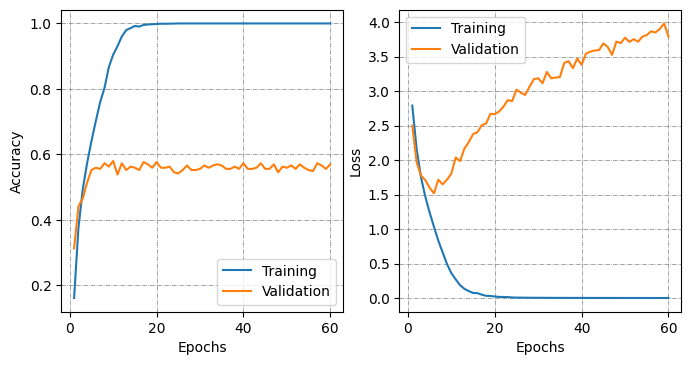

-------------------
Model: Baseline 1_1


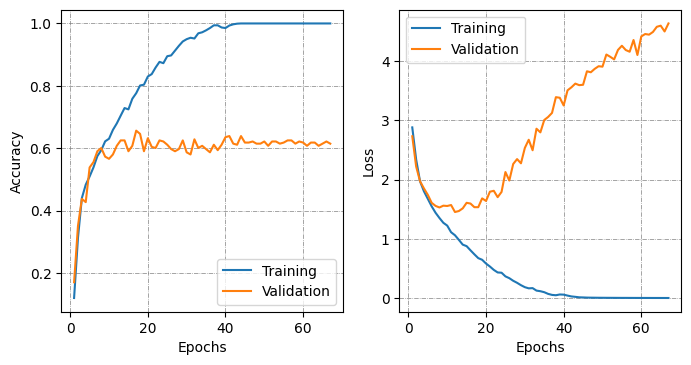

-------------------
Model: Baseline 2


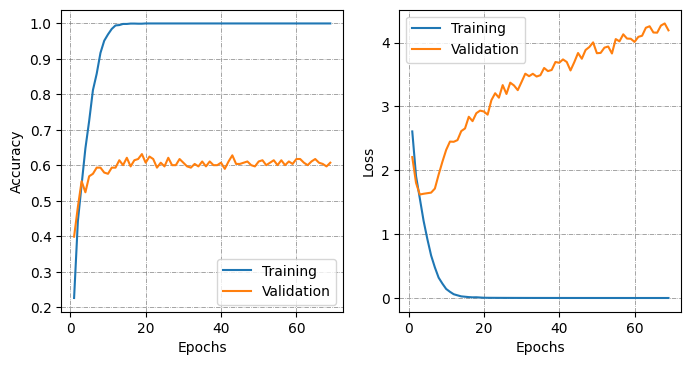

-------------------
Model: Baseline 2_1


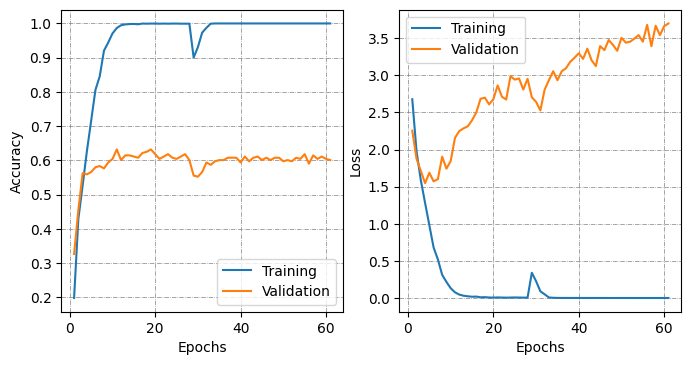

-------------------
Model: Baseline 2_2


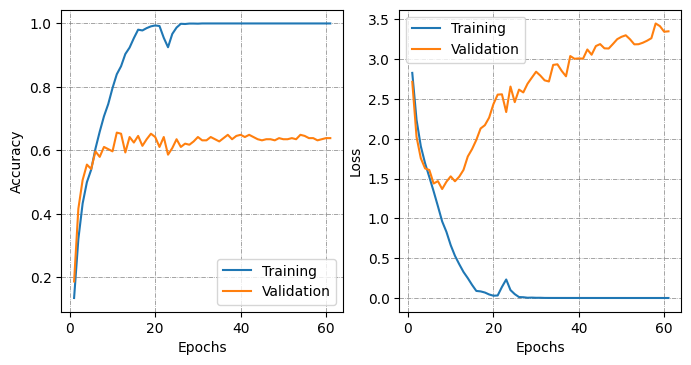

-------------------
Model: Baseline 2_3


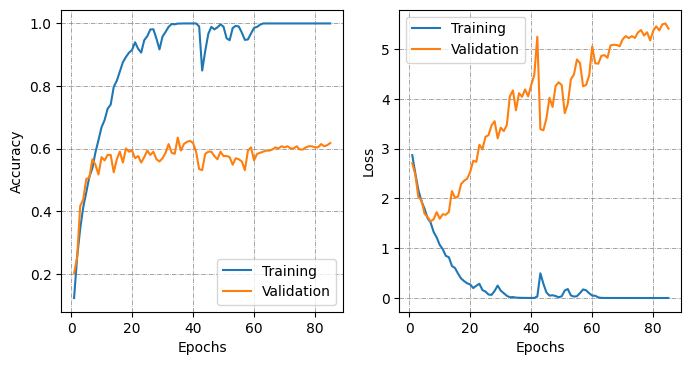

-------------------
Model: Baseline 3


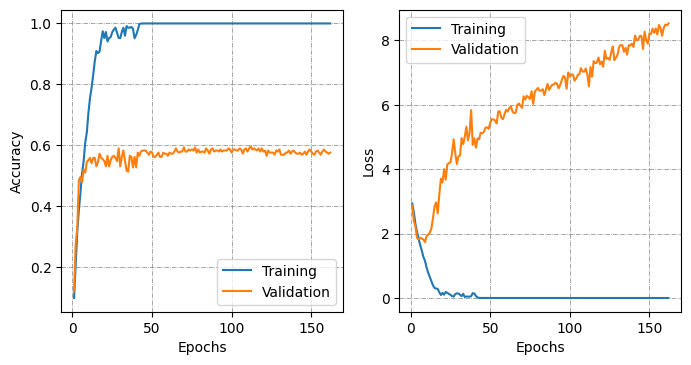

-------------------
Model: Baseline 3_1


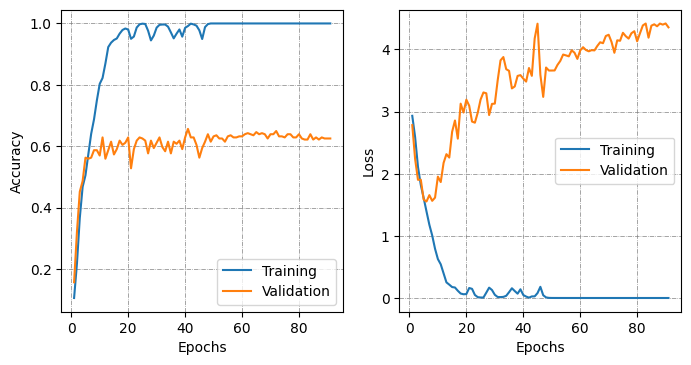

-------------------
Model: Baseline 3_2


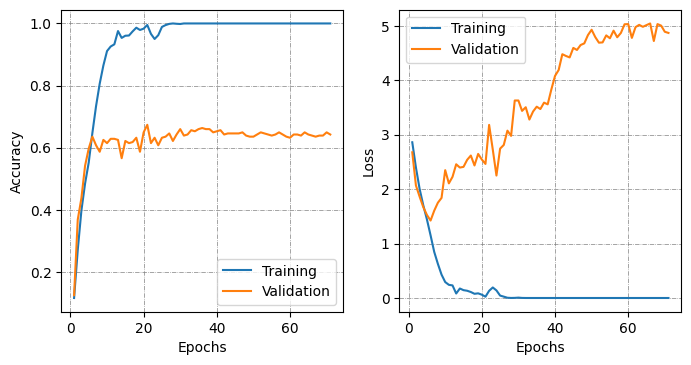

In [244]:
models=[history_1,history_1_1,history_2,history_2_1,history_2_2,history_2_3,history_3,history_3_1,history_3_2]

models_name = ["Baseline 1", "Baseline 1_1", "Baseline 2", "Baseline 2_1", "Baseline 2_2", "Baseline 2_3",
              "Baseline 3", "Baseline 3_1", "Baseline 3_2"]
i = 0
for model in models:
    print('-------------------')
    print("Model:", models_name[i])
    plot_results(model)
    plt.show()
    i= i + 1

#### Models Scores

In [264]:
models=[history_1,history_1_1,history_2,history_2_1,history_2_2,history_2_3,history_3,history_3_1,history_3_2]

models_name = ["Baseline 1", "Baseline 1_1", "Baseline 2", "Baseline 2_1", "Baseline 2_2", "Baseline 2_3",
              "Baseline 3", "Baseline 3_1", "Baseline 3_2"]

i = 0
for model in models:
    highest_val_acc = max(model.history['val_acc'])
    acc = max(model.history['acc'])
    print("Model:", models_name[i], '->', 'val_acc =',highest_val_acc, ',', 'train_acc =',acc)
    i = i + 1

Model: Baseline 1 -> val_acc = 0.5798611044883728 , train_acc = 1.0
Model: Baseline 1_1 -> val_acc = 0.65625 , train_acc = 1.0
Model: Baseline 2 -> val_acc = 0.6319444179534912 , train_acc = 1.0
Model: Baseline 2_1 -> val_acc = 0.6319444179534912 , train_acc = 1.0
Model: Baseline 2_2 -> val_acc = 0.65625 , train_acc = 1.0
Model: Baseline 2_3 -> val_acc = 0.6354166865348816 , train_acc = 1.0
Model: Baseline 3 -> val_acc = 0.5972222089767456 , train_acc = 1.0
Model: Baseline 3_1 -> val_acc = 0.65625 , train_acc = 1.0
Model: Baseline 3_2 -> val_acc = 0.6736111044883728 , train_acc = 1.0


In [69]:
baseline_model_1.save('baseline_model_1.h5')
baseline_model_1_1.save('baseline_model_1.h5')
baseline_model_2.save('baseline_model_1_1.h5')
baseline_model_2_1.save('baseline_model_2_1.h5')
baseline_model_2_2.save('baseline_model_2_2.h5')
baseline_model_2_3.save('baseline_model_2_3.h5')
baseline_model_3.save('baseline_model_3.h5')
baseline_model_3_1.save('baseline_model_3_1.h5')
baseline_model_3_2.save('baseline_model_3_2.h5')

#### Chosen model to tune

In [159]:
def extract_new_data(base_dir, verbose=True):
    training_dir = os.path.join(base_dir, 'train') 
    test_dir = os.path.join(base_dir, 'test') 
    val_dir = os.path.join(base_dir, 'valid')

    # Get data:
    train_data_generator = ImageDataGenerator(rescale=1./255)
    test_data_generator = ImageDataGenerator(rescale=1./255)
    validation_data_generator = ImageDataGenerator(rescale=1./255)

    # Note: do not forget to later adjust the value of the batch_size so you can obtain smoother training and validation curves:
    train_generator = train_data_generator.flow_from_directory(training_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    validation_generator = validation_data_generator.flow_from_directory(val_dir, target_size=(64,64), batch_size=32, class_mode='categorical')
    
    return train_generator, test_generator, validation_generator

In [160]:
base_dir = os.getcwd() + '/instruments'
train_generator, test_generator, val_generator = extract_data(base_dir=base_dir)

Found 2921 images belonging to 20 classes.
Found 300 images belonging to 20 classes.
Found 300 images belonging to 20 classes.


In [161]:
#3 conv layers
chosen_model = Sequential()

chosen_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
chosen_model.add(MaxPooling2D(pool_size=(2, 2)))

chosen_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
chosen_model.add(MaxPooling2D(pool_size=(2, 2)))

chosen_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
chosen_model.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
chosen_model.add(Flatten())
# MLP - hidden layer:
chosen_model.add(Dense(120, activation='relu'))
chosen_model.add(Dense(20, activation='softmax'))

# Check built model:
chosen_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 6, 6, 32)       

In [162]:
chosen_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])

In [163]:
# Common attributes:
steps_per_epoch = 90
epochs = 500
validation_steps = 9
patience=100
shuffle=True

In [164]:
early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [165]:
history_chosen = chosen_model.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
90/90 [==============================] - 7s 77ms/step - loss: 2.8890 - acc: 0.1229 - val_loss: 2.6283 - val_acc: 0.1806
Epoch 2/500
90/90 [==============================] - 7s 73ms/step - loss: 2.3353 - acc: 0.2937 - val_loss: 2.2397 - val_acc: 0.2917
Epoch 3/500
90/90 [==============================] - 7s 74ms/step - loss: 1.9515 - acc: 0.4274 - val_loss: 1.8985 - val_acc: 0.4306
Epoch 4/500
90/90 [==============================] - 7s 72ms/step - loss: 1.6928 - acc: 0.4967 - val_loss: 1.6843 - val_acc: 0.5069
Epoch 5/500
90/90 [==============================] - 6s 70ms/step - loss: 1.5470 - acc: 0.5485 - val_loss: 1.5711 - val_acc: 0.5556
Epoch 6/500
90/90 [==============================] - 6s 68ms/step - loss: 1.3256 - acc: 0.5999 - val_loss: 1.4635 - val_acc: 0.5799
Epoch 7/500
90/90 [==============================] - 6s 69ms/step - loss: 1.1556 - acc: 0.6577 - val_loss: 1.4633 - val_acc: 0.5729
Epoch 8/500
90/90 [==============================] - 6s 69ms/step - loss: 0.

90/90 [==============================] - 6s 70ms/step - loss: 4.5024e-06 - acc: 1.0000 - val_loss: 4.6482 - val_acc: 0.6528
Epoch 121/500
90/90 [==============================] - 6s 71ms/step - loss: 4.3181e-06 - acc: 1.0000 - val_loss: 4.5670 - val_acc: 0.6632
Epoch 122/500
90/90 [==============================] - 6s 69ms/step - loss: 4.0893e-06 - acc: 1.0000 - val_loss: 4.7975 - val_acc: 0.6458
Epoch 123/500
90/90 [==============================] - 6s 67ms/step - loss: 3.9230e-06 - acc: 1.0000 - val_loss: 4.5096 - val_acc: 0.6667
Epoch 124/500
90/90 [==============================] - 6s 71ms/step - loss: 3.7111e-06 - acc: 1.0000 - val_loss: 4.7046 - val_acc: 0.6667
Epoch 125/500
90/90 [==============================] - 6s 67ms/step - loss: 3.5281e-06 - acc: 1.0000 - val_loss: 4.6410 - val_acc: 0.6562
Epoch 126/500
90/90 [==============================] - 6s 66ms/step - loss: 3.3723e-06 - acc: 1.0000 - val_loss: 4.6715 - val_acc: 0.6597
Epoch 127/500
90/90 [===========================

### Regularization

#### Spatial Dropout model: Convolution layers (30%)

In [167]:
Conv_MaxPooling_Spatial = Sequential()

Conv_MaxPooling_Spatial.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
Conv_MaxPooling_Spatial.add(SpatialDropout2D(0.3))
Conv_MaxPooling_Spatial.add(MaxPooling2D(pool_size=(2, 2)))

Conv_MaxPooling_Spatial.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
Conv_MaxPooling_Spatial.add(SpatialDropout2D(0.3))
Conv_MaxPooling_Spatial.add(MaxPooling2D(pool_size=(2, 2)))

Conv_MaxPooling_Spatial.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
Conv_MaxPooling_Spatial.add(SpatialDropout2D(0.3))
Conv_MaxPooling_Spatial.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
Conv_MaxPooling_Spatial.add(Flatten())
# MLP - hidden layer:
Conv_MaxPooling_Spatial.add(Dense(120, activation='relu'))
Conv_MaxPooling_Spatial.add(Dense(20, activation='softmax'))

# Check built model:
Conv_MaxPooling_Spatial.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 62, 62, 32)       0         
 lDropout2D)                                                     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 spatial_dropout2d_4 (Spatia  (None, 29, 29, 32)       0         
 lDropout2D)                                                     
                                                     

#### Dropout model: Convolution layers (30%)

In [168]:
Conv_MaxPooling_DropOut = Sequential()

Conv_MaxPooling_DropOut.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
Conv_MaxPooling_DropOut.add(MaxPooling2D(pool_size=(2, 2)))
Conv_MaxPooling_DropOut.add(Dropout(0.3))

Conv_MaxPooling_DropOut.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
Conv_MaxPooling_DropOut.add(MaxPooling2D(pool_size=(2, 2)))
Conv_MaxPooling_DropOut.add(Dropout(0.3))

Conv_MaxPooling_DropOut.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
Conv_MaxPooling_DropOut.add(MaxPooling2D(pool_size=(2, 2)))
Conv_MaxPooling_DropOut.add(Dropout(0.3))

# MLP - input layer:
Conv_MaxPooling_DropOut.add(Flatten())
# MLP - hidden layer:
Conv_MaxPooling_DropOut.add(Dense(120, activation='relu'))
Conv_MaxPooling_DropOut.add(Dense(20, activation='softmax'))

# Check built model:
Conv_MaxPooling_DropOut.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 14, 14, 32)      

#### Dropout model: Hidden layers

In [169]:
hidden_drop = Sequential()

hidden_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
hidden_drop.add(MaxPooling2D(pool_size=(2, 2)))

hidden_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
hidden_drop.add(MaxPooling2D(pool_size=(2, 2)))

hidden_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
hidden_drop.add(MaxPooling2D(pool_size=(2, 2)))

# MLP - input layer:
hidden_drop.add(Flatten())
# MLP - hidden layer:
hidden_drop.add(Dense(120, activation='relu'))
hidden_drop.add(Dropout(0.3)) #0.2 0.3 0.5

hidden_drop.add(Dense(20, activation='softmax'))

# Check built model:
hidden_drop.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 6, 6, 32)       

#### Dropout model in the convolution and hidden layers

In [170]:
hidden_conv_drop = Sequential()

hidden_conv_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
hidden_conv_drop.add(MaxPooling2D(pool_size=(2, 2)))
hidden_conv_drop.add(Dropout(0.3)) #0.2 0.3 0.5

hidden_conv_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
hidden_conv_drop.add(MaxPooling2D(pool_size=(2, 2)))
hidden_conv_drop.add(Dropout(0.3)) #0.2 0.3 0.5

hidden_conv_drop.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
hidden_conv_drop.add(MaxPooling2D(pool_size=(2, 2)))
hidden_conv_drop.add(Dropout(0.3)) #0.2 0.3 0.5

# MLP - input layer:
hidden_conv_drop.add(Flatten())
# MLP - hidden layer:
hidden_conv_drop.add(Dense(120, activation='relu'))
hidden_conv_drop.add(Dropout(0.3)) #0.2 0.3 0.5

hidden_conv_drop.add(Dense(20, activation='softmax'))

# Check built model:
hidden_conv_drop.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 14, 14, 32)      

#### L2 Regularizer + Dropout model

In [171]:
l2_regularizer = Sequential()

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01),
                            input_shape=(64, 64, 3)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

l2_regularizer.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                            activation='relu', padding='valid',kernel_regularizer=l2(0.01)))
l2_regularizer.add(MaxPooling2D(pool_size=(2, 2)))
l2_regularizer.add(Dropout(0.3))

# MLP - input layer:
l2_regularizer.add(Flatten())
# MLP - hidden layer:
l2_regularizer.add(Dense(120, activation='relu',kernel_regularizer=l2(0.01)))
l2_regularizer.add(Dropout(0.3)) #0.2 0.3 0.5

l2_regularizer.add(Dense(20, activation='softmax'))

# Check built model:
l2_regularizer.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_85 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 14, 14, 32)      

In [172]:
Conv_MaxPooling_Spatial.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
Conv_MaxPooling_DropOut.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
hidden_drop.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
hidden_conv_drop.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics = ['acc'])
l2_regularizer.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics = ['acc'])

In [173]:
# Common attributes:
steps_per_epoch = 60
epochs = 500
validation_steps = 6
patience=100
shuffle=True

In [174]:
early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [175]:
history_Conv_MaxPooling_Spatial= Conv_MaxPooling_Spatial.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
60/60 [==============================] - 5s 77ms/step - loss: 2.9768 - acc: 0.0807 - val_loss: 3.0187 - val_acc: 0.0417
Epoch 2/500
60/60 [==============================] - 5s 75ms/step - loss: 2.9458 - acc: 0.0975 - val_loss: 2.9890 - val_acc: 0.0469
Epoch 3/500
60/60 [==============================] - 5s 75ms/step - loss: 2.9290 - acc: 0.0954 - val_loss: 2.9191 - val_acc: 0.0573
Epoch 4/500
60/60 [==============================] - 4s 72ms/step - loss: 2.7846 - acc: 0.1534 - val_loss: 2.6788 - val_acc: 0.1667
Epoch 5/500
60/60 [==============================] - 4s 71ms/step - loss: 2.6017 - acc: 0.2383 - val_loss: 2.3157 - val_acc: 0.3698
Epoch 6/500
60/60 [==============================] - 4s 73ms/step - loss: 2.3945 - acc: 0.3026 - val_loss: 2.0719 - val_acc: 0.3906
Epoch 7/500
60/60 [==============================] - 4s 70ms/step - loss: 2.2904 - acc: 0.3279 - val_loss: 2.0542 - val_acc: 0.4062
Epoch 8/500
60/60 [==============================] - 4s 69ms/step - loss: 2.

60/60 [==============================] - 4s 67ms/step - loss: 0.1008 - acc: 0.9721 - val_loss: 2.5598 - val_acc: 0.6354
Epoch 124/500
60/60 [==============================] - 4s 68ms/step - loss: 0.1144 - acc: 0.9710 - val_loss: 3.3589 - val_acc: 0.6094
Epoch 125/500
60/60 [==============================] - 4s 70ms/step - loss: 0.1534 - acc: 0.9531 - val_loss: 3.0551 - val_acc: 0.5938
Epoch 126/500
60/60 [==============================] - 4s 68ms/step - loss: 0.1168 - acc: 0.9626 - val_loss: 2.6035 - val_acc: 0.5990
Epoch 127/500
60/60 [==============================] - 4s 70ms/step - loss: 0.1370 - acc: 0.9625 - val_loss: 3.1072 - val_acc: 0.5990
Epoch 128/500
60/60 [==============================] - 4s 69ms/step - loss: 0.1187 - acc: 0.9620 - val_loss: 2.8387 - val_acc: 0.6198
Epoch 129/500
60/60 [==============================] - 4s 69ms/step - loss: 0.1142 - acc: 0.9682 - val_loss: 2.7954 - val_acc: 0.6302
Epoch 130/500
60/60 [==============================] - 4s 69ms/step - loss: 

In [176]:
history_Conv_MaxPooling_DropOut= Conv_MaxPooling_DropOut.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
60/60 [==============================] - 5s 69ms/step - loss: 2.9474 - acc: 0.0896 - val_loss: 2.9476 - val_acc: 0.0938
Epoch 2/500
60/60 [==============================] - 4s 68ms/step - loss: 2.7310 - acc: 0.1750 - val_loss: 2.5272 - val_acc: 0.2656
Epoch 3/500
60/60 [==============================] - 4s 69ms/step - loss: 2.3733 - acc: 0.2920 - val_loss: 2.3224 - val_acc: 0.3229
Epoch 4/500
60/60 [==============================] - 4s 67ms/step - loss: 2.2325 - acc: 0.3400 - val_loss: 2.1029 - val_acc: 0.3854
Epoch 5/500
60/60 [==============================] - 4s 68ms/step - loss: 2.0688 - acc: 0.3685 - val_loss: 1.9701 - val_acc: 0.4219
Epoch 6/500
60/60 [==============================] - 4s 67ms/step - loss: 1.9104 - acc: 0.4354 - val_loss: 1.9141 - val_acc: 0.4948
Epoch 7/500
60/60 [==============================] - 4s 68ms/step - loss: 1.8628 - acc: 0.4560 - val_loss: 1.8244 - val_acc: 0.5000
Epoch 8/500
60/60 [==============================] - 4s 67ms/step - loss: 1.

60/60 [==============================] - 4s 74ms/step - loss: 0.1106 - acc: 0.9636 - val_loss: 1.8890 - val_acc: 0.7031
Epoch 124/500
60/60 [==============================] - 4s 73ms/step - loss: 0.1143 - acc: 0.9641 - val_loss: 2.4570 - val_acc: 0.6719
Epoch 125/500
60/60 [==============================] - 4s 71ms/step - loss: 0.0886 - acc: 0.9731 - val_loss: 2.5126 - val_acc: 0.6354
Epoch 126/500
60/60 [==============================] - 4s 70ms/step - loss: 0.1045 - acc: 0.9694 - val_loss: 2.6319 - val_acc: 0.6458
Epoch 127/500
60/60 [==============================] - 4s 70ms/step - loss: 0.0950 - acc: 0.9668 - val_loss: 2.2770 - val_acc: 0.6198
Epoch 128/500
60/60 [==============================] - 4s 74ms/step - loss: 0.0769 - acc: 0.9694 - val_loss: 2.5642 - val_acc: 0.6406
Epoch 129/500
60/60 [==============================] - 5s 78ms/step - loss: 0.1274 - acc: 0.9646 - val_loss: 2.0084 - val_acc: 0.6615
Epoch 130/500
60/60 [==============================] - 5s 83ms/step - loss: 

60/60 [==============================] - 4s 73ms/step - loss: 0.0323 - acc: 0.9916 - val_loss: 2.2573 - val_acc: 0.6771
Epoch 246/500
60/60 [==============================] - 5s 76ms/step - loss: 0.0529 - acc: 0.9805 - val_loss: 2.5499 - val_acc: 0.6406


In [177]:
history_hidden_drop= hidden_drop.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
60/60 [==============================] - 7s 99ms/step - loss: 2.9601 - acc: 0.0719 - val_loss: 2.8653 - val_acc: 0.1562
Epoch 2/500
60/60 [==============================] - 4s 74ms/step - loss: 2.6578 - acc: 0.2104 - val_loss: 2.3296 - val_acc: 0.3073
Epoch 3/500
60/60 [==============================] - 5s 75ms/step - loss: 2.2565 - acc: 0.3281 - val_loss: 2.1066 - val_acc: 0.3698
Epoch 4/500
60/60 [==============================] - 5s 77ms/step - loss: 2.0962 - acc: 0.3859 - val_loss: 1.9684 - val_acc: 0.4583
Epoch 5/500
60/60 [==============================] - 4s 72ms/step - loss: 1.8636 - acc: 0.4507 - val_loss: 1.7550 - val_acc: 0.4844
Epoch 6/500
60/60 [==============================] - 4s 69ms/step - loss: 1.6661 - acc: 0.5008 - val_loss: 1.6740 - val_acc: 0.5260
Epoch 7/500
60/60 [==============================] - 4s 74ms/step - loss: 1.6041 - acc: 0.5198 - val_loss: 1.5760 - val_acc: 0.5469
Epoch 8/500
60/60 [==============================] - 4s 72ms/step - loss: 1.

60/60 [==============================] - 4s 67ms/step - loss: 0.0751 - acc: 0.9734 - val_loss: 2.9700 - val_acc: 0.6354
Epoch 124/500
60/60 [==============================] - 4s 69ms/step - loss: 0.0584 - acc: 0.9800 - val_loss: 2.7831 - val_acc: 0.6562
Epoch 125/500
60/60 [==============================] - 4s 69ms/step - loss: 0.0883 - acc: 0.9700 - val_loss: 2.7512 - val_acc: 0.6458
Epoch 126/500
60/60 [==============================] - 4s 71ms/step - loss: 0.0740 - acc: 0.9752 - val_loss: 3.0061 - val_acc: 0.6198
Epoch 127/500
60/60 [==============================] - 4s 71ms/step - loss: 0.0535 - acc: 0.9818 - val_loss: 2.9304 - val_acc: 0.6406
Epoch 128/500
60/60 [==============================] - 4s 68ms/step - loss: 0.0615 - acc: 0.9792 - val_loss: 3.0434 - val_acc: 0.6719
Epoch 129/500
60/60 [==============================] - 4s 71ms/step - loss: 0.0580 - acc: 0.9805 - val_loss: 2.9466 - val_acc: 0.6250
Epoch 130/500
60/60 [==============================] - 4s 69ms/step - loss: 

60/60 [==============================] - 4s 66ms/step - loss: 0.0305 - acc: 0.9901 - val_loss: 3.7324 - val_acc: 0.6562
Epoch 246/500
60/60 [==============================] - 4s 67ms/step - loss: 0.0311 - acc: 0.9884 - val_loss: 4.1587 - val_acc: 0.6510
Epoch 247/500
60/60 [==============================] - 4s 68ms/step - loss: 0.0346 - acc: 0.9896 - val_loss: 4.6870 - val_acc: 0.6354
Epoch 248/500
60/60 [==============================] - 4s 67ms/step - loss: 0.0469 - acc: 0.9833 - val_loss: 3.9399 - val_acc: 0.6146
Epoch 249/500
60/60 [==============================] - 4s 67ms/step - loss: 0.0388 - acc: 0.9873 - val_loss: 3.8692 - val_acc: 0.6042
Epoch 250/500
60/60 [==============================] - 4s 67ms/step - loss: 0.0421 - acc: 0.9852 - val_loss: 3.9240 - val_acc: 0.6458
Epoch 251/500
60/60 [==============================] - 4s 67ms/step - loss: 0.0417 - acc: 0.9868 - val_loss: 3.7918 - val_acc: 0.6510
Epoch 252/500
60/60 [==============================] - 4s 67ms/step - loss: 

In [178]:
history_hidden_conv_drop= hidden_conv_drop.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
60/60 [==============================] - 5s 73ms/step - loss: 3.0527 - acc: 0.0547 - val_loss: 2.9965 - val_acc: 0.0417
Epoch 2/500
60/60 [==============================] - 4s 72ms/step - loss: 2.9653 - acc: 0.0807 - val_loss: 2.9964 - val_acc: 0.0312
Epoch 3/500
60/60 [==============================] - 4s 71ms/step - loss: 2.9604 - acc: 0.0796 - val_loss: 2.9921 - val_acc: 0.0417
Epoch 4/500
60/60 [==============================] - 4s 71ms/step - loss: 2.9401 - acc: 0.0870 - val_loss: 2.9800 - val_acc: 0.0625
Epoch 5/500
60/60 [==============================] - 4s 70ms/step - loss: 2.9434 - acc: 0.0817 - val_loss: 2.9588 - val_acc: 0.1094
Epoch 6/500
60/60 [==============================] - 4s 71ms/step - loss: 2.9005 - acc: 0.1012 - val_loss: 2.9512 - val_acc: 0.0729
Epoch 7/500
60/60 [==============================] - 4s 71ms/step - loss: 2.8596 - acc: 0.1234 - val_loss: 2.9038 - val_acc: 0.1250
Epoch 8/500
60/60 [==============================] - 4s 70ms/step - loss: 2.

60/60 [==============================] - 4s 69ms/step - loss: 1.2953 - acc: 0.5974 - val_loss: 1.3493 - val_acc: 0.6146
Epoch 124/500
60/60 [==============================] - 4s 70ms/step - loss: 1.2867 - acc: 0.6052 - val_loss: 1.4431 - val_acc: 0.5938
Epoch 125/500
60/60 [==============================] - 4s 70ms/step - loss: 1.2684 - acc: 0.6099 - val_loss: 1.4225 - val_acc: 0.5990
Epoch 126/500
60/60 [==============================] - 4s 71ms/step - loss: 1.2695 - acc: 0.6057 - val_loss: 1.3700 - val_acc: 0.6094
Epoch 127/500
60/60 [==============================] - 4s 71ms/step - loss: 1.2977 - acc: 0.5930 - val_loss: 1.3149 - val_acc: 0.6094
Epoch 128/500
60/60 [==============================] - 4s 70ms/step - loss: 1.2411 - acc: 0.6241 - val_loss: 1.3192 - val_acc: 0.6042
Epoch 129/500
60/60 [==============================] - 4s 70ms/step - loss: 1.2824 - acc: 0.6010 - val_loss: 1.3533 - val_acc: 0.6302
Epoch 130/500
60/60 [==============================] - 4s 70ms/step - loss: 

60/60 [==============================] - 5s 78ms/step - loss: 0.7211 - acc: 0.7612 - val_loss: 1.2286 - val_acc: 0.6719
Epoch 246/500
60/60 [==============================] - 5s 75ms/step - loss: 0.6794 - acc: 0.7802 - val_loss: 1.0478 - val_acc: 0.7083
Epoch 247/500
60/60 [==============================] - 5s 78ms/step - loss: 0.7156 - acc: 0.7693 - val_loss: 1.1750 - val_acc: 0.6562
Epoch 248/500
60/60 [==============================] - 5s 78ms/step - loss: 0.7063 - acc: 0.7781 - val_loss: 1.2256 - val_acc: 0.6667
Epoch 249/500
60/60 [==============================] - 5s 82ms/step - loss: 0.7428 - acc: 0.7617 - val_loss: 1.1645 - val_acc: 0.6719
Epoch 250/500
60/60 [==============================] - 5s 82ms/step - loss: 0.6844 - acc: 0.7740 - val_loss: 1.1844 - val_acc: 0.6615
Epoch 251/500
60/60 [==============================] - 5s 76ms/step - loss: 0.7137 - acc: 0.7617 - val_loss: 1.2732 - val_acc: 0.6458
Epoch 252/500
60/60 [==============================] - 4s 75ms/step - loss: 

60/60 [==============================] - 4s 73ms/step - loss: 0.4388 - acc: 0.8482 - val_loss: 1.3249 - val_acc: 0.6823
Epoch 368/500
60/60 [==============================] - 4s 72ms/step - loss: 0.4107 - acc: 0.8629 - val_loss: 1.1143 - val_acc: 0.7031
Epoch 369/500
60/60 [==============================] - 4s 72ms/step - loss: 0.4484 - acc: 0.8487 - val_loss: 1.1453 - val_acc: 0.6927
Epoch 370/500
60/60 [==============================] - 4s 74ms/step - loss: 0.4337 - acc: 0.8619 - val_loss: 1.3676 - val_acc: 0.6458
Epoch 371/500
60/60 [==============================] - 5s 77ms/step - loss: 0.4565 - acc: 0.8513 - val_loss: 1.2098 - val_acc: 0.6875
Epoch 372/500
60/60 [==============================] - 4s 71ms/step - loss: 0.4586 - acc: 0.8487 - val_loss: 1.3408 - val_acc: 0.6354
Epoch 373/500
60/60 [==============================] - 5s 75ms/step - loss: 0.4023 - acc: 0.8656 - val_loss: 1.4180 - val_acc: 0.6198
Epoch 374/500
60/60 [==============================] - 5s 75ms/step - loss: 

In [179]:
history_l2= l2_regularizer.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/500
60/60 [==============================] - 5s 71ms/step - loss: 5.7817 - acc: 0.0643 - val_loss: 5.6409 - val_acc: 0.0521
Epoch 2/500
60/60 [==============================] - 4s 70ms/step - loss: 5.5085 - acc: 0.0785 - val_loss: 5.4268 - val_acc: 0.0417
Epoch 3/500
60/60 [==============================] - 4s 67ms/step - loss: 5.2891 - acc: 0.0854 - val_loss: 5.2143 - val_acc: 0.0469
Epoch 4/500
60/60 [==============================] - 4s 68ms/step - loss: 5.0764 - acc: 0.0954 - val_loss: 5.0201 - val_acc: 0.0417
Epoch 5/500
60/60 [==============================] - 4s 68ms/step - loss: 4.8751 - acc: 0.0948 - val_loss: 4.8336 - val_acc: 0.0573
Epoch 6/500
60/60 [==============================] - 4s 68ms/step - loss: 4.7075 - acc: 0.0938 - val_loss: 4.6762 - val_acc: 0.0521
Epoch 7/500
60/60 [==============================] - 4s 68ms/step - loss: 4.5480 - acc: 0.0901 - val_loss: 4.5239 - val_acc: 0.0729
Epoch 8/500
60/60 [==============================] - 4s 68ms/step - loss: 4.

60/60 [==============================] - 4s 70ms/step - loss: 1.8800 - acc: 0.5479 - val_loss: 1.8292 - val_acc: 0.6198
Epoch 124/500
60/60 [==============================] - 4s 70ms/step - loss: 1.8884 - acc: 0.5503 - val_loss: 1.9273 - val_acc: 0.5938
Epoch 125/500
60/60 [==============================] - 4s 69ms/step - loss: 1.8875 - acc: 0.5488 - val_loss: 1.9676 - val_acc: 0.5729
Epoch 126/500
60/60 [==============================] - 4s 68ms/step - loss: 1.8233 - acc: 0.5599 - val_loss: 1.9250 - val_acc: 0.5885
Epoch 127/500
60/60 [==============================] - 4s 68ms/step - loss: 1.8332 - acc: 0.5651 - val_loss: 1.8948 - val_acc: 0.5625
Epoch 128/500
60/60 [==============================] - 4s 69ms/step - loss: 1.8760 - acc: 0.5458 - val_loss: 1.9526 - val_acc: 0.5729
Epoch 129/500
60/60 [==============================] - 4s 68ms/step - loss: 1.8342 - acc: 0.5667 - val_loss: 1.9177 - val_acc: 0.5625
Epoch 130/500
60/60 [==============================] - 4s 69ms/step - loss: 

60/60 [==============================] - 4s 67ms/step - loss: 1.4839 - acc: 0.6858 - val_loss: 1.7748 - val_acc: 0.6146
Epoch 246/500
60/60 [==============================] - 4s 68ms/step - loss: 1.5013 - acc: 0.6742 - val_loss: 1.8971 - val_acc: 0.5990
Epoch 247/500
60/60 [==============================] - 4s 68ms/step - loss: 1.4881 - acc: 0.6729 - val_loss: 1.7754 - val_acc: 0.6302
Epoch 248/500
60/60 [==============================] - 4s 69ms/step - loss: 1.4905 - acc: 0.6724 - val_loss: 1.8276 - val_acc: 0.6198
Epoch 249/500
60/60 [==============================] - 4s 68ms/step - loss: 1.4882 - acc: 0.6705 - val_loss: 1.7579 - val_acc: 0.6771
Epoch 250/500
60/60 [==============================] - 4s 67ms/step - loss: 1.5055 - acc: 0.6763 - val_loss: 1.6709 - val_acc: 0.6667
Epoch 251/500
60/60 [==============================] - 4s 67ms/step - loss: 1.4867 - acc: 0.6758 - val_loss: 1.6689 - val_acc: 0.6510
Epoch 252/500
60/60 [==============================] - 4s 68ms/step - loss: 

Epoch 367/500
60/60 [==============================] - 7s 111ms/step - loss: 1.2855 - acc: 0.7433 - val_loss: 1.8720 - val_acc: 0.6198
Epoch 368/500
60/60 [==============================] - 7s 112ms/step - loss: 1.2664 - acc: 0.7491 - val_loss: 1.8800 - val_acc: 0.6094
Epoch 369/500
60/60 [==============================] - 7s 114ms/step - loss: 1.2724 - acc: 0.7589 - val_loss: 1.7849 - val_acc: 0.6302
Epoch 370/500
60/60 [==============================] - 8s 136ms/step - loss: 1.2397 - acc: 0.7672 - val_loss: 1.8694 - val_acc: 0.6146
Epoch 371/500
60/60 [==============================] - 7s 112ms/step - loss: 1.2754 - acc: 0.7507 - val_loss: 1.7249 - val_acc: 0.6458
Epoch 372/500
60/60 [==============================] - 7s 111ms/step - loss: 1.2497 - acc: 0.7654 - val_loss: 1.9066 - val_acc: 0.6094
Epoch 373/500
60/60 [==============================] - 7s 111ms/step - loss: 1.2734 - acc: 0.7580 - val_loss: 1.6761 - val_acc: 0.6615
Epoch 374/500
60/60 [==============================] - 

In [180]:
models=[chosen_model,Conv_MaxPooling_Spatial,Conv_MaxPooling_DropOut,
        hidden_drop,hidden_conv_drop,l2_regularizer]

for model in models:
    model.evaluate(test_generator, steps=8)

8/8 [==============================] - 1s 171ms/step - loss: 1.6034 - acc: 0.7227


### Save models

In [181]:
chosen_model.save('chosen_model.h5')
Conv_MaxPooling_Spatial.save('Conv_MaxPooling_Spatial.h5')
Conv_MaxPooling_DropOut.save('Conv_MaxPooling_DropOut.h5')
hidden_drop.save('hidden_drop.h5')
hidden_conv_drop.save('hidden_conv_drop.h5')
l2_regularizer.save('l2_regularizer.h5')

### Data augmentation

In [230]:
base_dir = os.getcwd() + '/instruments'
train_generator, test_generator, val_generator = extract_data(base_dir=base_dir)

Found 2921 images belonging to 20 classes.
Found 300 images belonging to 20 classes.
Found 300 images belonging to 20 classes.


In [231]:
training_dir = os.path.join(base_dir, 'train') 
new_train_data_generator = ImageDataGenerator(
        rescale=1/255,
        ##rotation_range=90,
        horizontal_flip=True, 
        vertical_flip=True, 
        
        fill_mode='nearest'
)

new_train_generator = new_train_data_generator.flow_from_directory(training_dir, target_size=(64,64), batch_size=32, class_mode='categorical')

Found 2921 images belonging to 20 classes.


In [232]:
#3 conv layers
chosen_model_aug = Sequential()

chosen_model_aug.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid', input_shape=(64, 64, 3)))
chosen_model_aug.add(MaxPooling2D(pool_size=(2, 2)))
chosen_model_aug.add(Dropout(0.3))

chosen_model_aug.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
chosen_model_aug.add(MaxPooling2D(pool_size=(2, 2)))
chosen_model_aug.add(Dropout(0.3))

chosen_model_aug.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid'))
chosen_model_aug.add(MaxPooling2D(pool_size=(2, 2)))
chosen_model_aug.add(Dropout(0.3))

# MLP - input layer:
chosen_model_aug.add(Flatten())
# MLP - hidden layer:
chosen_model_aug.add(Dense(120, activation='relu'))
chosen_model_aug.add(Dropout(0.3))
chosen_model_aug.add(Dense(20, activation='softmax'))

# Check built model:
chosen_model_aug.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_61 (Dropout)        (None, 14, 14, 32)      

In [233]:
chosen_model_aug.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics = ['acc'])
early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [234]:
# Common attributes:
steps_per_epoch = 60
epochs = 500
validation_steps = 6
patience=100
shuffle=True

early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [235]:
history_aug = chosen_model_aug.fit(new_train_generator,
                                                      steps_per_epoch=steps_per_epoch,
                                                      validation_data=val_generator,
                                                      validation_steps=validation_steps,
                                                      epochs=epochs,
                                                      callbacks=[early_stop],
                                                      shuffle=shuffle
                                                     )

Epoch 1/500
60/60 [==============================] - 5s 83ms/step - loss: 2.9652 - acc: 0.0923 - val_loss: 2.9738 - val_acc: 0.0677
Epoch 2/500
60/60 [==============================] - 5s 78ms/step - loss: 2.9078 - acc: 0.1115 - val_loss: 2.8796 - val_acc: 0.0938
Epoch 3/500
60/60 [==============================] - 5s 77ms/step - loss: 2.7856 - acc: 0.1529 - val_loss: 2.6952 - val_acc: 0.1927
Epoch 4/500
60/60 [==============================] - 5s 81ms/step - loss: 2.6630 - acc: 0.1914 - val_loss: 2.6048 - val_acc: 0.2083
Epoch 5/500
60/60 [==============================] - 5s 82ms/step - loss: 2.5688 - acc: 0.2188 - val_loss: 2.4541 - val_acc: 0.2865
Epoch 6/500
60/60 [==============================] - 5s 83ms/step - loss: 2.4875 - acc: 0.2472 - val_loss: 2.3701 - val_acc: 0.3177
Epoch 7/500
60/60 [==============================] - 5s 83ms/step - loss: 2.4456 - acc: 0.2635 - val_loss: 2.3832 - val_acc: 0.2865
Epoch 8/500
60/60 [==============================] - 5s 81ms/step - loss: 2.

60/60 [==============================] - 5s 78ms/step - loss: 1.1600 - acc: 0.6373 - val_loss: 1.1040 - val_acc: 0.6927
Epoch 63/500
60/60 [==============================] - 5s 79ms/step - loss: 1.2008 - acc: 0.6136 - val_loss: 1.1462 - val_acc: 0.6562
Epoch 64/500
60/60 [==============================] - 5s 80ms/step - loss: 1.1639 - acc: 0.6226 - val_loss: 1.1023 - val_acc: 0.7344
Epoch 65/500
60/60 [==============================] - 5s 80ms/step - loss: 1.1716 - acc: 0.6422 - val_loss: 1.1636 - val_acc: 0.6667
Epoch 66/500
60/60 [==============================] - 5s 81ms/step - loss: 1.1231 - acc: 0.6469 - val_loss: 1.1949 - val_acc: 0.6667
Epoch 67/500
60/60 [==============================] - 5s 78ms/step - loss: 1.1042 - acc: 0.6516 - val_loss: 1.1576 - val_acc: 0.7031
Epoch 68/500
60/60 [==============================] - 5s 80ms/step - loss: 1.1770 - acc: 0.6363 - val_loss: 1.2843 - val_acc: 0.6562
Epoch 69/500
60/60 [==============================] - 5s 80ms/step - loss: 1.1372 

60/60 [==============================] - 5s 86ms/step - loss: 0.8611 - acc: 0.7201 - val_loss: 1.2611 - val_acc: 0.6875
Epoch 124/500
60/60 [==============================] - 5s 86ms/step - loss: 0.8255 - acc: 0.7266 - val_loss: 1.1724 - val_acc: 0.6667
Epoch 125/500
60/60 [==============================] - 5s 85ms/step - loss: 0.8851 - acc: 0.7001 - val_loss: 1.2815 - val_acc: 0.6823
Epoch 126/500
60/60 [==============================] - 5s 84ms/step - loss: 0.8187 - acc: 0.7328 - val_loss: 1.0987 - val_acc: 0.7135
Epoch 127/500
60/60 [==============================] - 5s 83ms/step - loss: 0.8808 - acc: 0.7094 - val_loss: 1.1732 - val_acc: 0.7396
Epoch 128/500
60/60 [==============================] - 5s 86ms/step - loss: 0.8871 - acc: 0.7083 - val_loss: 1.1429 - val_acc: 0.6875
Epoch 129/500
60/60 [==============================] - 5s 85ms/step - loss: 0.8688 - acc: 0.7132 - val_loss: 1.2348 - val_acc: 0.6406
Epoch 130/500
60/60 [==============================] - 5s 84ms/step - loss: 

60/60 [==============================] - 5s 77ms/step - loss: 0.7057 - acc: 0.7654 - val_loss: 1.0054 - val_acc: 0.7292
Epoch 185/500
60/60 [==============================] - 5s 79ms/step - loss: 0.7538 - acc: 0.7443 - val_loss: 1.1877 - val_acc: 0.6875
Epoch 186/500
60/60 [==============================] - 5s 77ms/step - loss: 0.7536 - acc: 0.7443 - val_loss: 1.1040 - val_acc: 0.7135
Epoch 187/500
60/60 [==============================] - 5s 78ms/step - loss: 0.7264 - acc: 0.7617 - val_loss: 1.1349 - val_acc: 0.7031
Epoch 188/500
60/60 [==============================] - 5s 79ms/step - loss: 0.7266 - acc: 0.7596 - val_loss: 1.0946 - val_acc: 0.7344
Epoch 189/500
60/60 [==============================] - 5s 78ms/step - loss: 0.6893 - acc: 0.7698 - val_loss: 1.0872 - val_acc: 0.7031
Epoch 190/500
60/60 [==============================] - 5s 78ms/step - loss: 0.7000 - acc: 0.7734 - val_loss: 1.1193 - val_acc: 0.6979
Epoch 191/500
60/60 [==============================] - 5s 77ms/step - loss: 

60/60 [==============================] - 5s 77ms/step - loss: 0.6609 - acc: 0.7886 - val_loss: 0.9485 - val_acc: 0.7708
Epoch 246/500
60/60 [==============================] - 5s 80ms/step - loss: 0.6711 - acc: 0.7802 - val_loss: 1.2014 - val_acc: 0.6979
Epoch 247/500
60/60 [==============================] - 5s 78ms/step - loss: 0.6694 - acc: 0.7745 - val_loss: 0.9695 - val_acc: 0.7344
Epoch 248/500
60/60 [==============================] - 5s 78ms/step - loss: 0.6558 - acc: 0.7876 - val_loss: 1.0621 - val_acc: 0.7292
Epoch 249/500
60/60 [==============================] - 5s 79ms/step - loss: 0.6179 - acc: 0.8013 - val_loss: 1.2858 - val_acc: 0.6979
Epoch 250/500
60/60 [==============================] - 5s 82ms/step - loss: 0.6538 - acc: 0.7855 - val_loss: 1.2228 - val_acc: 0.6823
Epoch 251/500
60/60 [==============================] - 5s 84ms/step - loss: 0.6184 - acc: 0.7979 - val_loss: 1.1700 - val_acc: 0.7083
Epoch 252/500
60/60 [==============================] - 5s 82ms/step - loss: 

60/60 [==============================] - 5s 86ms/step - loss: 0.6122 - acc: 0.7969 - val_loss: 1.2798 - val_acc: 0.6823
Epoch 307/500
60/60 [==============================] - 5s 83ms/step - loss: 0.5550 - acc: 0.8208 - val_loss: 1.0498 - val_acc: 0.7240
Epoch 308/500
60/60 [==============================] - 5s 82ms/step - loss: 0.5812 - acc: 0.7934 - val_loss: 1.2438 - val_acc: 0.7135
Epoch 309/500
60/60 [==============================] - 5s 80ms/step - loss: 0.5998 - acc: 0.8023 - val_loss: 1.0187 - val_acc: 0.7500
Epoch 310/500
60/60 [==============================] - 5s 82ms/step - loss: 0.5874 - acc: 0.8129 - val_loss: 1.2273 - val_acc: 0.7292
Epoch 311/500
60/60 [==============================] - 5s 79ms/step - loss: 0.6106 - acc: 0.8010 - val_loss: 1.2132 - val_acc: 0.7135
Epoch 312/500
60/60 [==============================] - 5s 79ms/step - loss: 0.5707 - acc: 0.8068 - val_loss: 1.2293 - val_acc: 0.7396
Epoch 313/500
60/60 [==============================] - 5s 77ms/step - loss: 

In [259]:
models=[chosen_model_aug]

for model in models:
    model.evaluate(test_generator, steps=7)

7/7 [==============================] - 1s 104ms/step - loss: 0.8735 - acc: 0.7634


### Pre-trained models

In [189]:
def extract_new_data(base_dir, verbose=True):
    training_dir = os.path.join(base_dir, 'train') 
    test_dir = os.path.join(base_dir, 'test') 
    val_dir = os.path.join(base_dir, 'valid')

    # Get data:
    train_data_generator = ImageDataGenerator(rescale=1./255)
    test_data_generator = ImageDataGenerator(rescale=1./255)
    validation_data_generator = ImageDataGenerator(rescale=1./255)

    # Note: do not forget to later adjust the value of the batch_size so you can obtain smoother training and validation curves:
    train_generator = train_data_generator.flow_from_directory(training_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
    test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
    validation_generator = validation_data_generator.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
    
    return train_generator, test_generator, validation_generator

In [190]:
base_dir = os.getcwd() + '/instruments'
train_generator, test_generator, val_generator = extract_new_data(base_dir=base_dir)

Found 2921 images belonging to 20 classes.
Found 300 images belonging to 20 classes.
Found 300 images belonging to 20 classes.


In [191]:
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [192]:
pre_trained_model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=20, activation="softmax")])

In [193]:
pre_trained_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['acc'])

In [194]:
# Common attributes:
steps_per_epoch = 60
epochs = 20
validation_steps = 6
patience=4
shuffle=True

In [195]:
early_stop = EarlyStopping(patience=patience, monitor='val_acc', mode='max', restore_best_weights=True) 

In [196]:
history_pretrained_mobilenet = pre_trained_model.fit(train_generator,epochs = epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stop],
                    shuffle=shuffle)

Epoch 1/20
60/60 [==============================] - 38s 599ms/step - loss: 1.0351 - acc: 0.7206 - val_loss: 0.1742 - val_acc: 0.9531
Epoch 2/20
60/60 [==============================] - 36s 596ms/step - loss: 0.1272 - acc: 0.9736 - val_loss: 0.1322 - val_acc: 0.9792
Epoch 3/20
60/60 [==============================] - 37s 610ms/step - loss: 0.0669 - acc: 0.9910 - val_loss: 0.1006 - val_acc: 0.9896
Epoch 4/20
60/60 [==============================] - 38s 629ms/step - loss: 0.0370 - acc: 0.9958 - val_loss: 0.1014 - val_acc: 0.9896
Epoch 5/20
60/60 [==============================] - 36s 593ms/step - loss: 0.0305 - acc: 0.9974 - val_loss: 0.0591 - val_acc: 0.9948
Epoch 6/20
60/60 [==============================] - 37s 619ms/step - loss: 0.0190 - acc: 0.9989 - val_loss: 0.0904 - val_acc: 0.9896
Epoch 7/20
60/60 [==============================] - 36s 606ms/step - loss: 0.0175 - acc: 0.9984 - val_loss: 0.0496 - val_acc: 0.9948
Epoch 8/20
60/60 [==============================] - 36s 602ms/step - 

In [197]:
models=[pre_trained_model]

for model in models:
    model.evaluate(test_generator, steps=8)

8/8 [==============================] - 5s 560ms/step - loss: 0.0543 - acc: 0.9805


In [198]:
pre_trained_model.evaluate(test_generator, steps=3)

3/3 [==============================] - 2s 556ms/step - loss: 0.0603 - acc: 0.9896


[0.060252442955970764, 0.9895833134651184]

### Models scores

In [266]:
models=[history_chosen,history_Conv_MaxPooling_Spatial,history_Conv_MaxPooling_DropOut,
        history_hidden_drop,history_hidden_conv_drop, history_l2, history_aug,history_pretrained_mobilenet]

models_name = ["Baseline 2_2", "Spatial Dropout model: Convolution Layers", "Dropout model: Convolution layers",
               "Dropout model: Hidden layers", "Dropout model: Convolution layers + Hidden layers", 
               "L2 Regularization", "Data Augmentation", "Pre-Trained Mobilenet"]

i = 0
for model in models:
    highest_val_acc = max(model.history['val_acc'])
    acc = max(model.history['acc'])
    print("Model:", models_name[i], '->', 'val_acc =',highest_val_acc, ',', 'train_acc =',acc)
    i = i + 1

Model: Baseline 2_2 -> val_acc = 0.6770833134651184 , train_acc = 1.0
Model: Spatial Dropout model: Convolution Layers -> val_acc = 0.671875 , train_acc = 0.9720611572265625
Model: Dropout model: Convolution layers -> val_acc = 0.7291666865348816 , train_acc = 0.9915656447410583
Model: Dropout model: Hidden layers -> val_acc = 0.7135416865348816 , train_acc = 0.995312511920929
Model: Dropout model: Convolution layers + Hidden layers -> val_acc = 0.7239583134651184 , train_acc = 0.8812500238418579
Model: L2 Regularization -> val_acc = 0.6927083134651184 , train_acc = 0.7932291626930237
Model: Data Augmentation -> val_acc = 0.78125 , train_acc = 0.8207696080207825
Model: Pre-Trained Mobilenet -> val_acc = 0.9947916865348816 , train_acc = 1.0


------------------- // -------------------
Model: Baseline 2_2


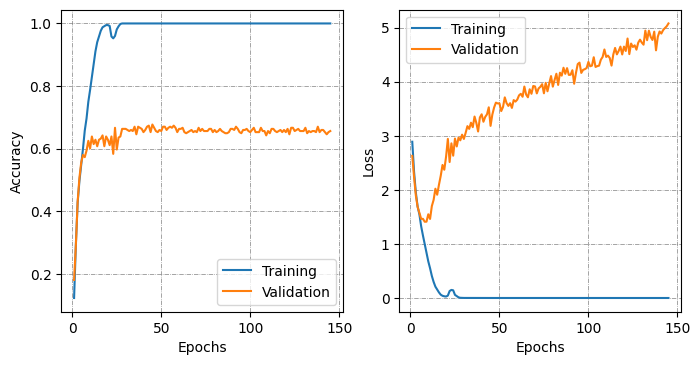

------------------- // -------------------
Model: Spatial Dropout model: Convolution Layers


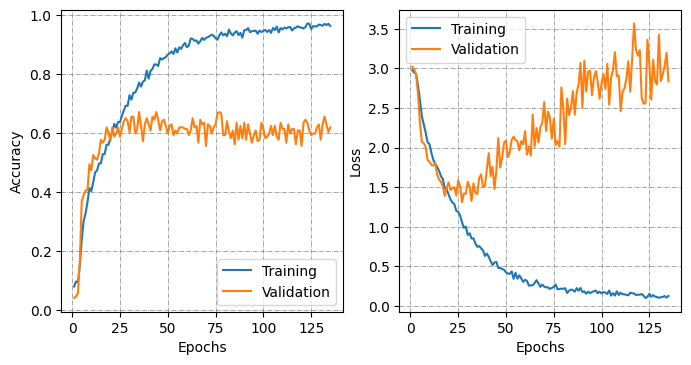

------------------- // -------------------
Model: Dropout model: Convolution layers


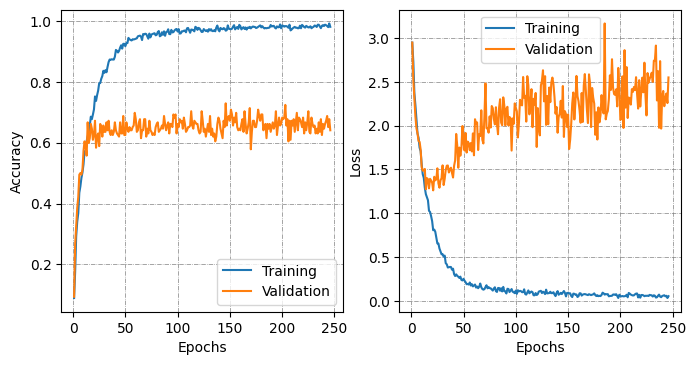

------------------- // -------------------
Model: Dropout model: Hidden layers


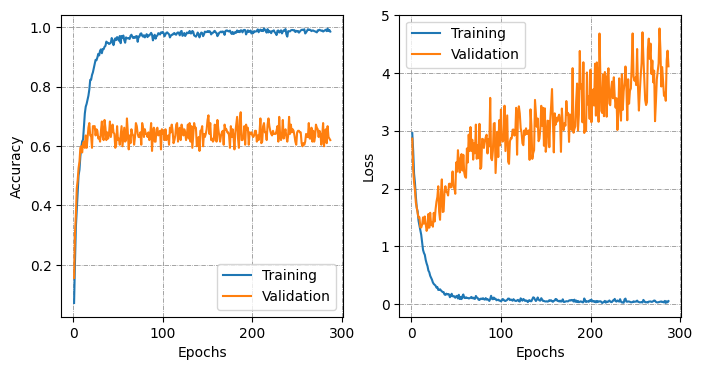

------------------- // -------------------
Model: Dropout model: Convolution layers + Hidden layers


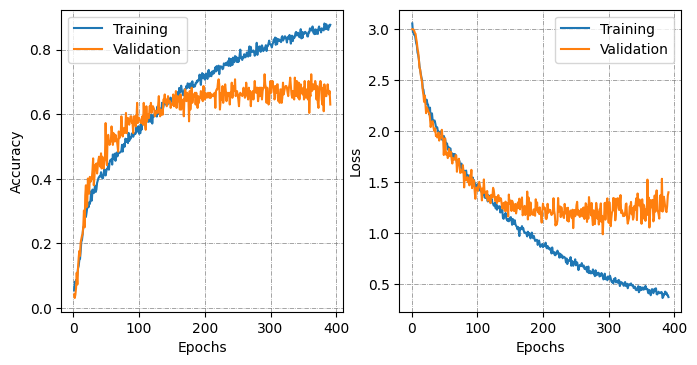

------------------- // -------------------
Model: L2 Regularization


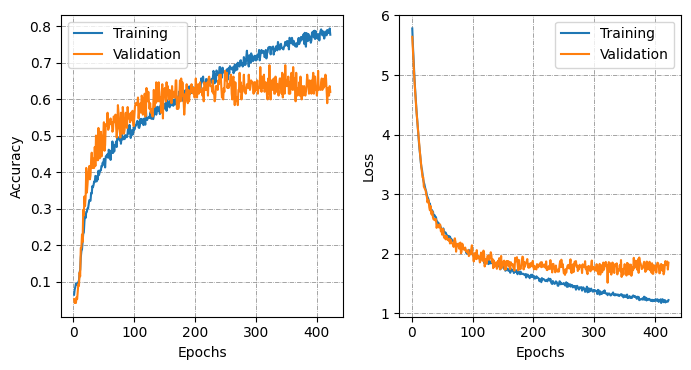

------------------- // -------------------
Model: Data Augmentation


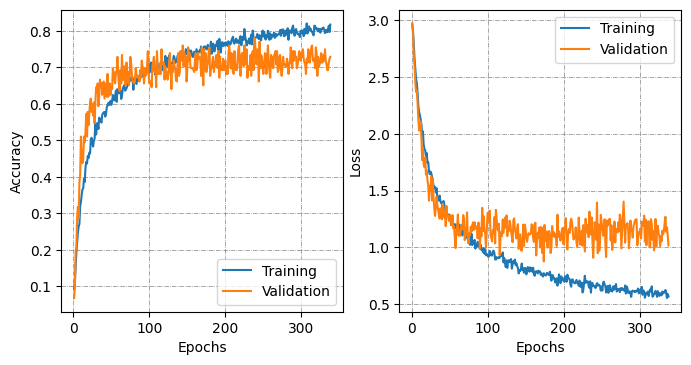

------------------- // -------------------
Model: Pre-Trained Mobilenet


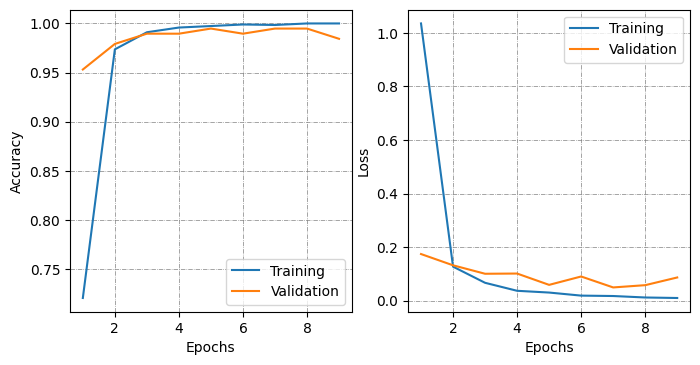

In [267]:
models=[history_chosen,history_Conv_MaxPooling_Spatial,history_Conv_MaxPooling_DropOut,
        history_hidden_drop,history_hidden_conv_drop,history_l2, history_aug,history_pretrained_mobilenet]

models_name = ["Baseline 2_2", "Spatial Dropout model: Convolution Layers", "Dropout model: Convolution layers",
               "Dropout model: Hidden layers", "Dropout model: Convolution layers + Hidden layers", 
               "L2 Regularization", "Data Augmentation", "Pre-Trained Mobilenet"]

i = 0
for model in models:
    print('------------------- // -------------------')
    print("Model:", models_name[i])
    plot_results(model)
    plt.show()
    i = i + 1